In [442]:
%matplotlib inline
import math
import json
import pickle
import random
from gensim import models
from gensim import matutils
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from nltk.tokenize import sent_tokenize
import glob
import argparse
import os
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time
path2files="/Users/ashishkumar/cs598dmcs//dataset/"
path2buisness=path2files+"yelp_academic_dataset_business.json"
path2reviews=path2files+"yelp_academic_dataset_review.json"



In [443]:
categories = set([]) # categories of restaurants
restaurant_ids = set([]) # set of restaurant ids
cat2rid = {} # stores restaurants id for each category
rid2cat = {}  # maps restaurants id to category mapping
rest2rate={} # stores restaurant rating
rid2name = {} # restaurant id to name
r = 'Restaurants'
with open (path2buisness, 'r') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        bjc = business_json['categories']
        #cities.add(business_json['city'])
        if r in bjc:
            if len(bjc) > 1:
                #print(bjc)
                restaurant_ids.add(business_json['business_id'])
                rid2cat[business_json['business_id']] = []
                categories = set(bjc).union(categories) - set([r])
                stars = business_json['stars']
                rest2rate[ business_json['business_id'] ] = stars
                for cat in bjc:
                    if cat == r:
                        continue
                    if cat in cat2rid:
                        cat2rid[cat].append(business_json['business_id'])
                        rid2cat[business_json['business_id']].append(cat)
                        #rid2name[business_json['business_id']].append(business_json['name'])
                    else:
                        cat2rid[cat] = [business_json['business_id']]
                        rid2cat[business_json['business_id']] = [cat]
                rid2name[business_json['business_id']] = [ business_json['name'] ]
                        

In [444]:
rest2revID = {} # stores restaurant to review ID
cat2reviews = {} # stores reviews for each category
cat2ratings = {} # stores ratings of each review for each category
cat2revID = {} # stores review_id of review for a category
cat2rid = {} # store restaurant id of review for a category
cat2rating = {} # store ratings for review for a category

with open (path2reviews, 'r') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if review_json['business_id'] in restaurant_ids:
            if review_json['business_id'] in rest2revID:
                rest2revID[ review_json['business_id'] ].append(review_json['review_id'])
            else:
                rest2revID[ review_json['business_id'] ] = [ review_json['review_id'] ]
        if review_json['business_id'] in rid2cat:
            for rcat in rid2cat[ review_json['business_id'] ]:
                if rcat in cat2reviews:
                    cat2reviews [ rcat ].append(review_json['text'])
                    cat2ratings [ rcat ].append( str(review_json['stars']) )
                    cat2revID [ rcat ].append(review_json['review_id'])
                    cat2rid [ rcat ].append(review_json['business_id'])
                    cat2rating[ rcat ].append(review_json['stars'])
                else:
                    cat2reviews [ rcat ] = [review_json['text']]
                    cat2ratings [ rcat ] = [ str(review_json['stars']) ]
                    cat2revID [ rcat ] = [ review_json['review_id'] ]
                    cat2rid [ rcat ] = [ review_json['business_id'] ]
                    cat2rating[ rcat ] = [review_json['stars']]
                

In [445]:
cuisine='Indian'

'''
at this point, we have 
rest2revID = {} # stores restaurant to review ID
cat2reviews = {} # stores reviews for each category
cat2ratings = {} # stores ratings of each review for each category
categories = set([]) # categories of restaurants
restaurant_ids = set([]) # set of restaurant ids
cat2rid = {} # stores restaurants id for each category
rid2cat = {}  # maps restaurants id to category mapping
rest2rate={} # stores restaurant rating
'''


In [446]:
dishFile=path2files + cuisine + ".label"
f= open(dishFile,'r')
dishNames = f.read().splitlines()
len(dishNames)

100

In [447]:
n_features = 100000
print("Extracting tf-idf features....")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   ngram_range=(1, 4),
                                   max_features=n_features,
                                   stop_words='english',
                                   sublinear_tf=False)

Extracting tf-idf features....


In [448]:
mergedReviews = cat2reviews[cuisine] + cat2reviews['Food']
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(mergedReviews)
print("done in %0.3fs." % (time() - t0))

done in 68.746s.


In [449]:
tfidf_features = tfidf_vectorizer.get_feature_names()
tfidf_counts = tfidf.sum(axis=0).A1

In [450]:
tfidfDict = {}
for i in range(n_features):
    tfidfDict[tfidf_features[i]] = tfidf_counts[i]

In [451]:
dishes = []
dishFreq = []
for dish in tfidf_features:
    if dish in dishNames:
        dishes.append(dish)
        dishFreq.append(tfidfDict[dish])
popdf = pd.DataFrame(data={'dish':dishes,'count':dishFreq})
popdf = popdf.sort_values(by='count',ascending=False)

In [453]:
catAvgRating = []
barColors = []
colorScheme = ['red','orange','gold','lightgreen','darkblue','darkblue']
for dish in popdf['dish']:
    indices =  [i for i,s in enumerate(cat2reviews[cuisine]) if dish in s]
    avgRating = 0
    if len(indices) > 0:
        for i in indices:
            avgRating = avgRating + int(cat2ratings[cuisine][i])
        avgRating = avgRating/len(indices) 
        
    indices2 =  [i for i,s in enumerate(cat2reviews['Food']) if dish in s]
    avgRating1 = 0
    if len(indices2) > 0:
        for i in indices2:
            avgRating1 = avgRating + int(cat2ratings['Food'][i])
        avgRating1 = avgRating1/len(indices2) 
        totAvg = (avgRating * len(indices)+avgRating1 * len(indices2))/(len(indices) + len(indices2))
    else:
        totAvg = avgRating
    #print(dish,"Avg Rating", avgRating, len(indices), avgRating1,len(indices2),totAvg)    
    catAvgRating.append(totAvg)
    barColors.append(colorScheme[math.ceil(int(totAvg))])
    
catAvgRatingdf = pd.DataFrame(data={'dish':popdf['dish'],'avgRating':catAvgRating})

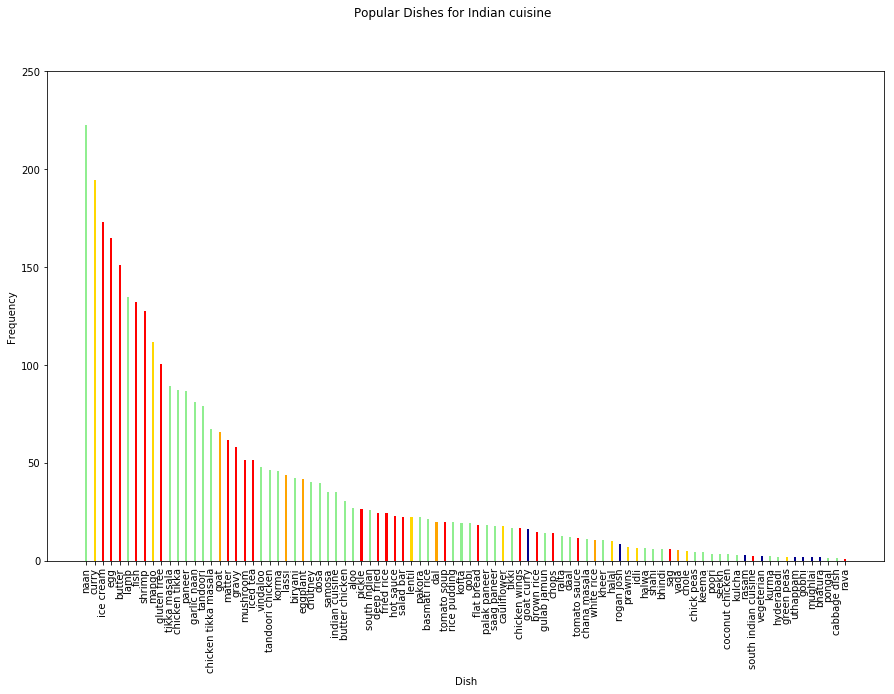

In [455]:
import matplotlib.pyplot as plt 
x = np.arange(len(dishes))
mytks = np.arange(0, 6*len(dishes), 6)
plt.ylabel('Frequency')
plt.xlabel('Dish')
plt.ylim([0,250])
plt.xticks(mytks, popdf['dish'], rotation=90)
plt.suptitle("Popular Dishes for " + cuisine + " cuisine")
rect = plt.bar(mytks,popdf['count'], width=1.5,color=barColors)
# Set figure width to 12 and height to 9
fig_size=[15,9]
plt.rcParams["figure.figsize"] = fig_size
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.show()

Part 5
Recommend good restaurants to those who would like to try one or more dishes in a cuisine. Given a particular dish, the general idea of solving this problem is to assess whether a restaurant is good for this dish based on whether the reviews of a candidate restaurant have included many positive (and very few negative) comments about the dish. You may choose a target dish or a set of target dishes from the list of "popular dishes" you generated from Task 4 or, otherwise, choose any dishes that have been mentioned many times in the review data (the more reviews you have for a dish, the more basis you will have for ranking restaurants). 

In [456]:
####
## WARNING : Change this list, if you change the value of global variable cuisine at top
####
#hand pick top 20 dishes in the Indian cuisine
dishList = ['naan','curry','butter','lamb','shrimp',
            'chicken','tikka','masala','korma','biryani',
            'paneer','goat','saag','fish','gravy',
            'basmati','samosa','vindaloo','tandoori','lassi']
dish2rid = {}

dish2AvgRating = []
for dish in dishList:
    # find index of review for a dish
    indices =  [i for i,s in enumerate(cat2reviews[cuisine]) if dish in s]
    for idx in indices:
        drid = cat2rid[cuisine][idx]
        drating = cat2rating[cuisine][idx]
        if dish not in dish2rid:
            dish2rid[dish] = [(drid, drating)]
        else: 
            if drid not in dish2rid[dish]:
                dish2rid[dish].append((drid,drating))
    '''
    # we can look into reviews under Food label as well (it is very generic label 
    # and likely to have indian entries)
    # but dishList must be very specific. generic terms such as chicken will skew results
    
    indices =  [i for i,s in enumerate(cat2reviews['Food']) if dish in s]
    for idx in indices:
        drid = cat2rid['Food'][idx]
        drating = cat2rating['Food'][idx]
        if dish not in dish2rid:
            dish2rid[dish] = [(drid, drating)]
        else: 
            if drid not in dish2rid[dish]:
                dish2rid[dish].append((drid,drating))   
    '''                
    ratingSum = {}
    for r,s in dish2rid[dish]:
        if r not in ratingSum:
            ratingSum[r] = [s]
        else:
            ratingSum[r].append(s)
    for r in ratingSum: 
        avg = sum(ratingSum[r])/float(len(ratingSum[r]))
        dish2AvgRating.append((dish,rid2name[r][0],avg))
        #print(dish,r,avg) 



In [458]:

dish2avgRatingdf = pd.DataFrame(np.array(dish2AvgRating))
dish2avgRatingdf.columns = ['dish','rid','avgRating']
dish2avgRatingdf = dish2avgRatingdf.sort_values(by=['dish','avgRating'],ascending=[True,False])


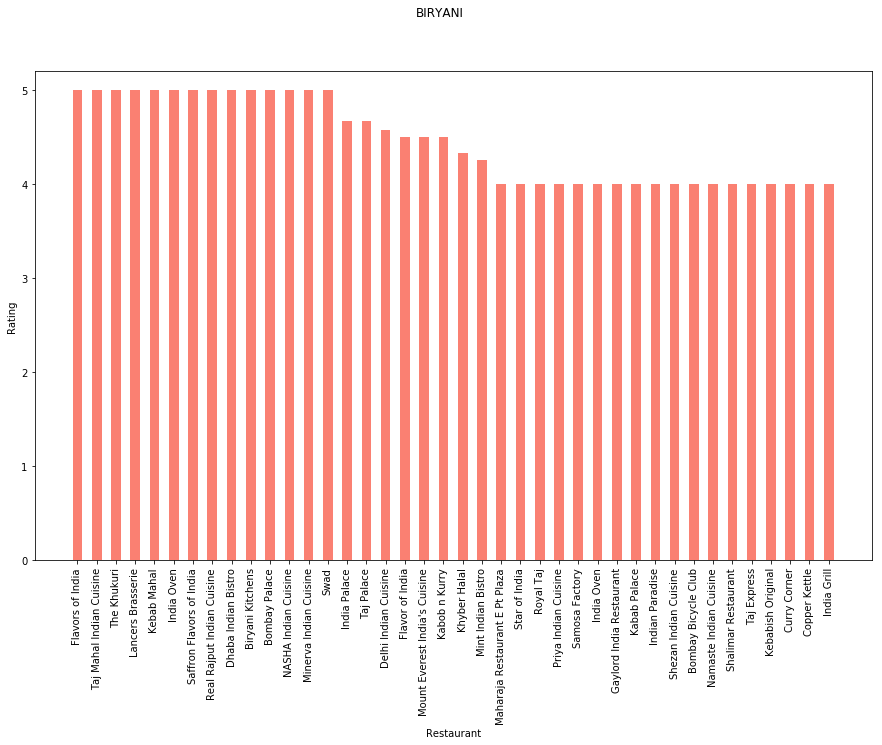

In [460]:
import matplotlib.pyplot as plt 
#show top 10 restaurants for a given dish type
def showRestRanking(id):
    maxRest = 40
    searchDish = dishList[id]
    results = dish2avgRatingdf.loc[dish2avgRatingdf['dish'] == searchDish].head(maxRest)
    x = np.arange(maxRest)
    mytks = np.arange(0, 6*maxRest, 6)
    plt.ylabel('Rating')
    plt.xlabel('Restaurant')
    plt.suptitle(searchDish.upper())
    plt.ylim([0,5.2])
    plt.xticks(mytks, results['rid'], rotation=90)
    rect = plt.bar(mytks,results['avgRating'], width=3,color='salmon')
    plt.show()
'''
0-'naan',1-'curry',2-'butter',3-'lamb',4-'shrimp',
5-'chicken',6-'tikka',7-'masala',8-'korma',9-'biryani',
10-'paneer',11-'goat',12-'saag',13-'fish',14-'gravy',
15-'basmati',16-'samosa',17-'vindaloo',18-'tandoori',19-'lassi']
'''
# valid values 0 - 19
showRestRanking(9)